### IMPORTS

In [ ]:
# IMPORTS
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
import imblearn as imb

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# to split the data
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from custom_adaboost import *

# to evaluate the models
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# Some functions
from utils import *

### ***2. Machine Learning Methods:***
#### 2.1. Apply at least 3 different machine learning methods
##### Apply at least 3 different machine learning methods on your selected problem. The methods should be selected from the ones covered in the course. None of the methods are allowed to be deep learning. For each method, you should test the effect of the hyperparameters and try to find a set of hyperparameter values that work well for your problem 
##### 2.2. You should apply all the concepts you learned in the course (such as Generalization and Combating Overfitting)
Our problem is a binary classification problem , and the labels are in the target column => Supervised Learning and Classification

#### Split Data to Train & Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

##### Method 1: Logistic Regression Model

##### A-Simple Model

In [ ]:
#################################################### Model Training ####################################################
#Build simple model. No parameter's Tuning
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

Training Accuracy: 0.8608088930936613
Testing Accuracy: 0.8625039419741406
Confusion Matrix: 
 [[42763   976]
 [ 6000   997]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.98      0.92     43739
           1       0.51      0.14      0.22      6997

    accuracy                           0.86     50736
   macro avg       0.69      0.56      0.57     50736
weighted avg       0.83      0.86      0.83     50736



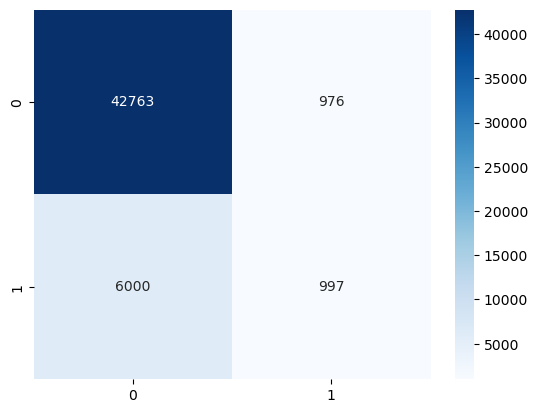

AUC: 0.810


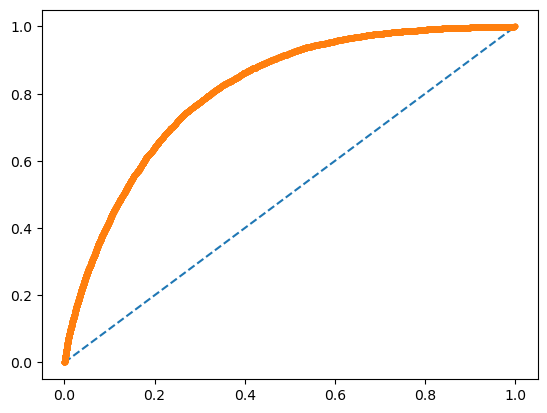

In [ ]:
#################################################### Model Evaluation ####################################################
# Evaluate model
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("Confusion Matrix: \n", conf_matrix)
print("Classification Report: \n", class_report)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

#ROC-AUC Curve
# predict probabilities and keep postive outcomes only
probs = lr_model.predict_proba(X_test)
probs = probs[:, 1]

# AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)

# ROC
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.show()


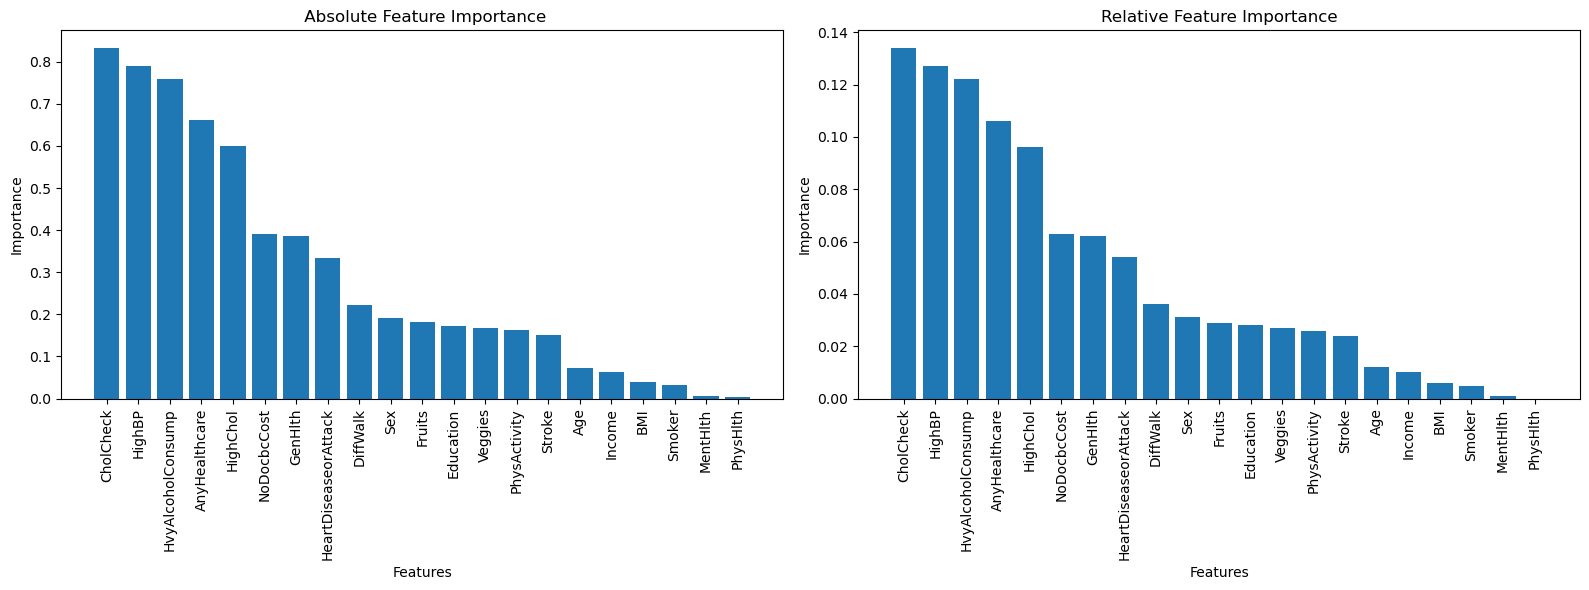

In [ ]:
#################################################### Feature's Importance ####################################################
#1-Absolute Feature Importance
feature_importance = {}
for idx, feature_name in enumerate(features):
	importance = abs(lr_model.coef_[0][idx]).round(3)  # Get the absolute value of the coefficient
	feature_importance[feature_name] = importance
sorted_feature_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True))

# Extract feature names and importances
features_plot_x = list(sorted_feature_importance.keys())
importances_plot_y = list(sorted_feature_importance.values())

plt.figure(figsize=(16, 6))  
plt.subplot(1, 2, 1) 
plt.bar(features_plot_x, importances_plot_y)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title(' Absolute Feature Importance')

#2-Relative Feature Importance
# Calculate total importance
total_importance = sum(importances_plot_y)
relative_importances = [(importance / total_importance).round(3) for importance in importances_plot_y]

plt.subplot(1, 2, 2)
plt.bar(features_plot_x, relative_importances)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Relative Feature Importance')

plt.tight_layout() 
plt.show()

# print("Feature Importance (Absolute): ", relative_importances)

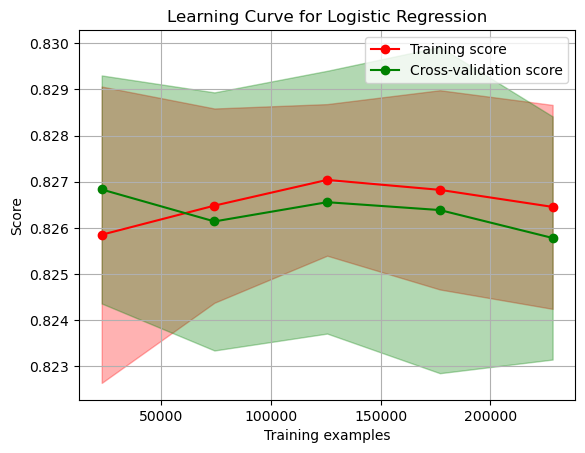

In [ ]:
# Get the learning curve plot
train_sizes, train_scores, test_scores = learning_curve(lr_model, features, labels, cv=10,
                                                            train_sizes=np.linspace(.1, 1.0, 5),
                                                            scoring='f1_weighted', shuffle=True, random_state=42)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve for Logistic Regression")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
					train_scores_mean + train_scores_std, alpha=0.3, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
					test_scores_mean + test_scores_std, alpha=0.3, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
			label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
			label="Cross-validation score")

plt.legend(loc='best')
plt.show()

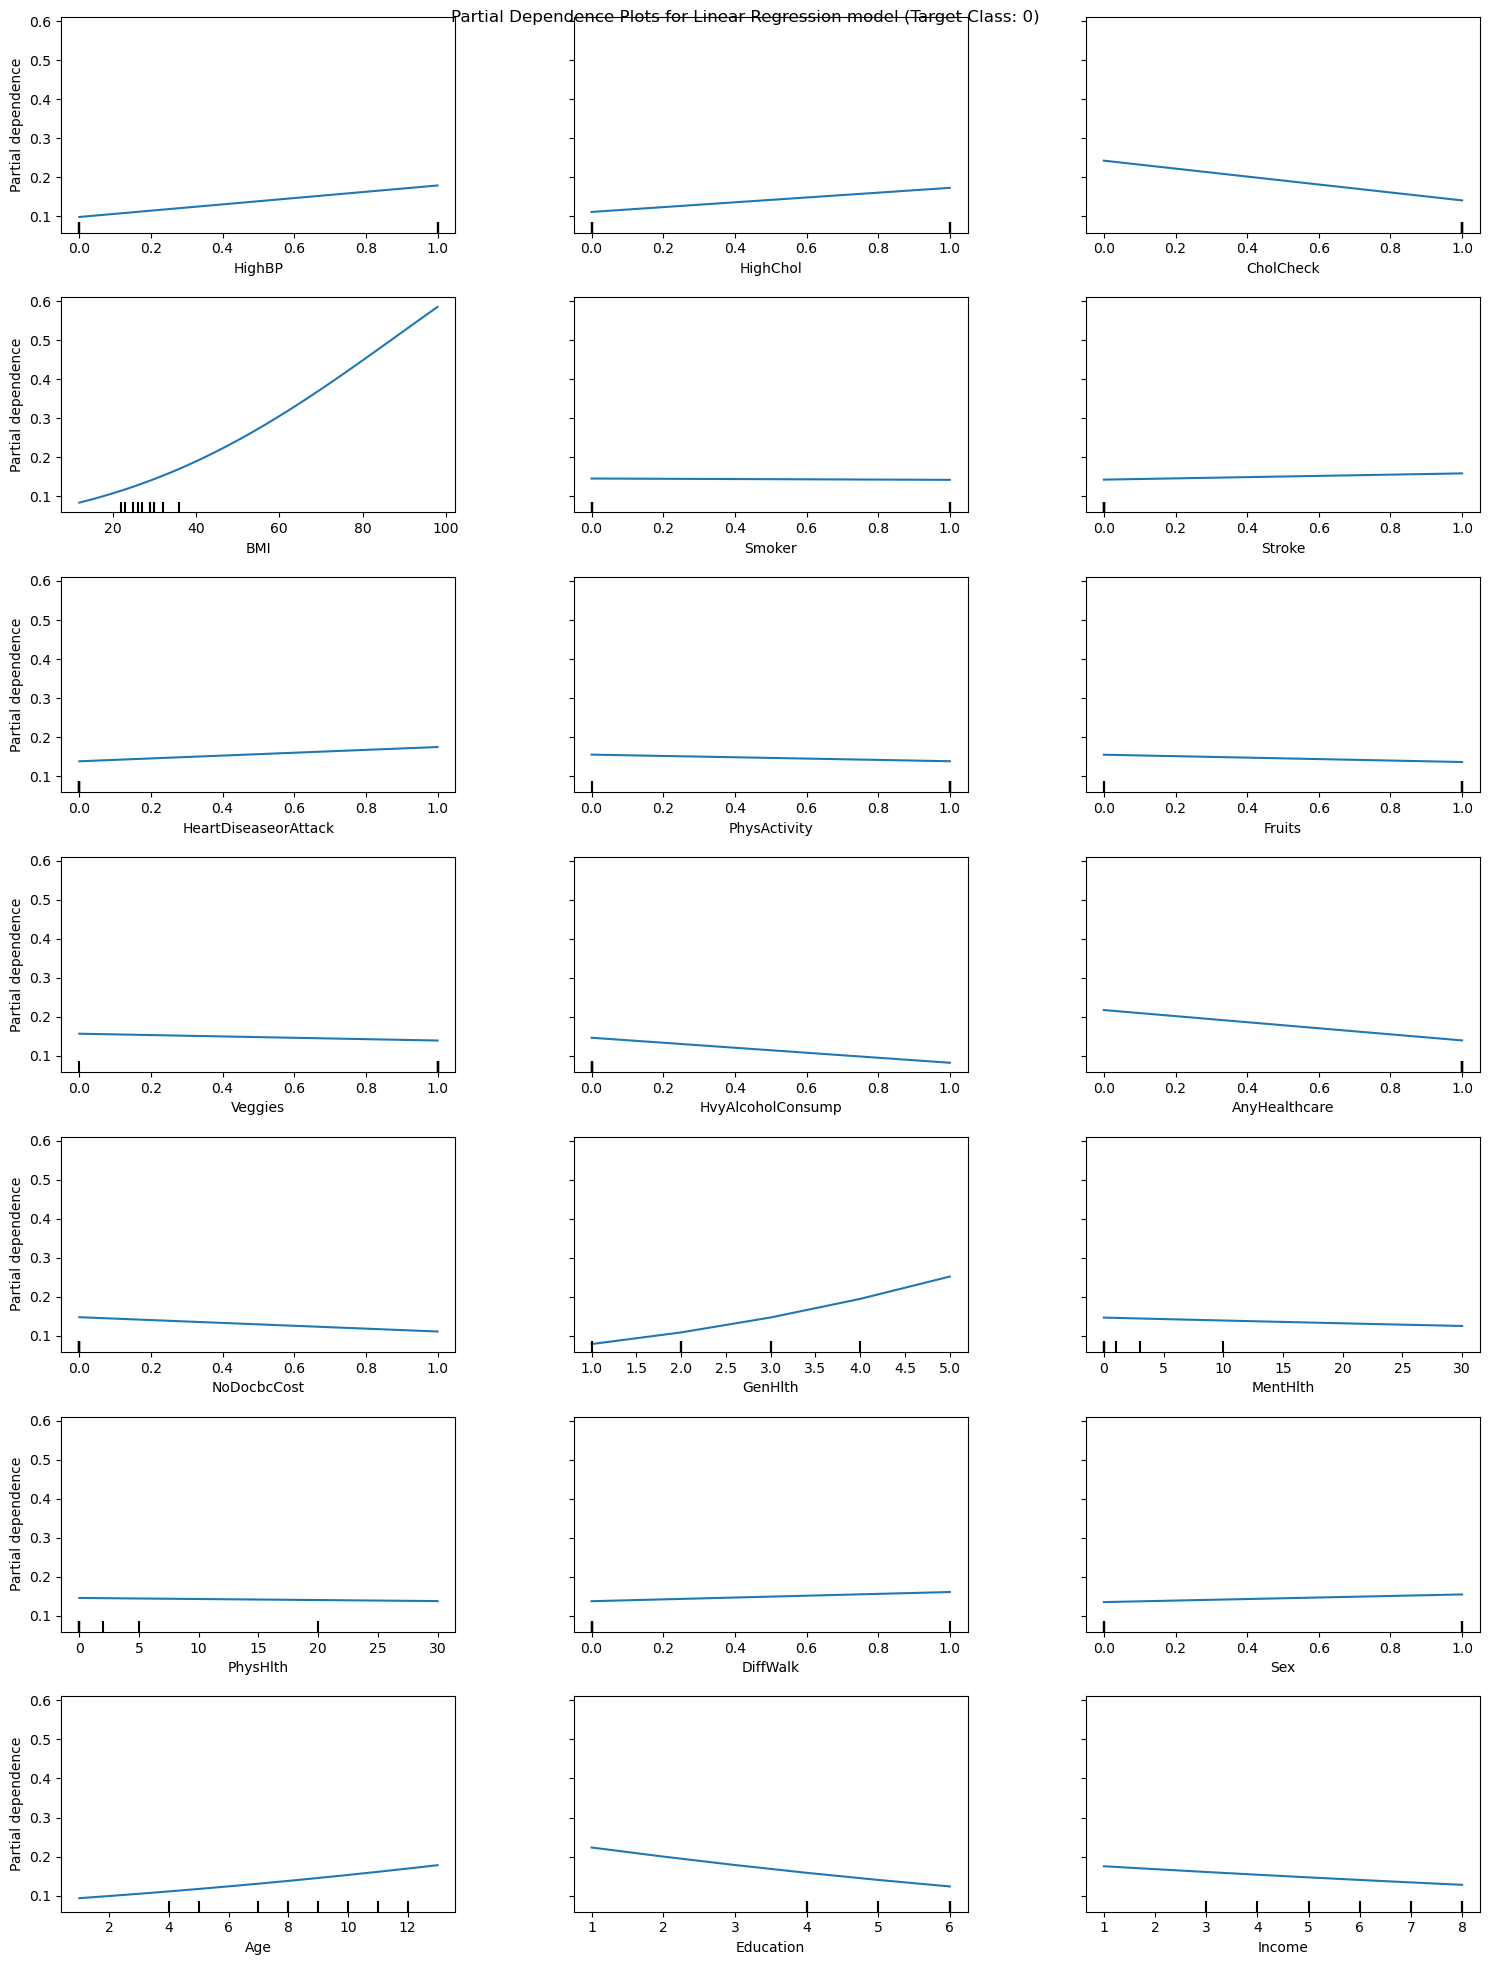

In [ ]:
# Model's Features Dependencies
'''
This is to show the relationship between a feature and the model's predictions (with all other features constant)

'''
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(15, 20), )
target_class = 0  # specify the target class
PartialDependenceDisplay.from_estimator(
	lr_model, features, features.columns, ax=ax, target=target_class)

# Increase spacing between subplots
fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle(f'Partial Dependence Plots for Linear Regression model (Target Class: {target_class})')
fig.tight_layout()
plt.show()


##### B-Tuned Model

In [ ]:
#################################################### Hyper Parameter Tuning ####################################################
'''
penalty: Specifies the norm used in the penalization. It can be one of {'l1', 'l2', 'elasticnet', 'none'}. The default is 'l2'.
C: Inverse of regularization strength. Smaller values specify stronger regularization, which can help prevent overfitting.
solver: Algorithm to use in the optimization problem. It can be one of {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}. The default is 'lbfgs'. The choice of solver may depend on the size of the dataset and the regularization.
multi_class: Specifies the strategy to use for multiclass classification. It can be one of {'auto', 'ovr', 'multinomial'}. The default is 'auto'. 'ovr' stands for One-vs-Rest, and 'multinomial' stands for Multinomial Logistic Regression.
max_iter: Maximum number of iterations for the solver to converge. The default is 100.
dual: Dual or primal formulation. Dual formulation is only implemented for 'liblinear' solver when the number of samples is less than the number of features.
fit_intercept: Whether to fit the intercept term.
intercept_scaling: Useful only when the solver 'liblinear' is used and self.fit_intercept is set to True. It scales the intercept term.
class_weight: Weights associated with classes. This parameter is particularly useful for imbalanced datasets.
verbose: Controls the verbosity of the Logistic Regression algorithm.
random_state: Random seed used by the random number generator.
'''
